In [8]:
#Starter code prepared by Borna Ghotbi, Polina Zablotskaia, and Ariel Shann for Computer Vision
#based on a MATLAB code by James Hays and Sam Birch 

import numpy as np
# from util import load, build_vocabulary, get_bags_of_sifts
# from classifiers import nearest_neighbor_classify, svm_classify

#For this assignment, you will need to report performance for sift features on two different classifiers:
# 1) Bag of sift features and nearest neighbor classifier
# 2) Bag of sift features and linear SVM classifier

#For simplicity you can define a "num_train_per_cat" vairable, limiting the number of
#examples per category. num_train_per_cat = 100 for intance.

#Sample images from the training/testing dataset. 
#You can limit number of samples by using the n_sample parameter.

print('Getting paths and labels for all train and test data\n')
train_image_paths, train_labels = load("sift/train")
test_image_paths, test_labels = load("sift/test")
       

''' Step 1: Represent each image with the appropriate feature
 Each function to construct features should return an N x d matrix, where
 N is the number of paths passed to the function and d is the 
 dimensionality of each image representation. See the starter code for
 each function for more details. '''

        
print('Extracting SIFT features\n')
#TODO: You code build_vocabulary function in util.py
kmeans = build_vocabulary(train_image_paths, vocab_size=200)

#TODO: You code get_bags_of_sifts function in util.py 
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)   

Getting paths and labels for all train and test data

Extracting SIFT features



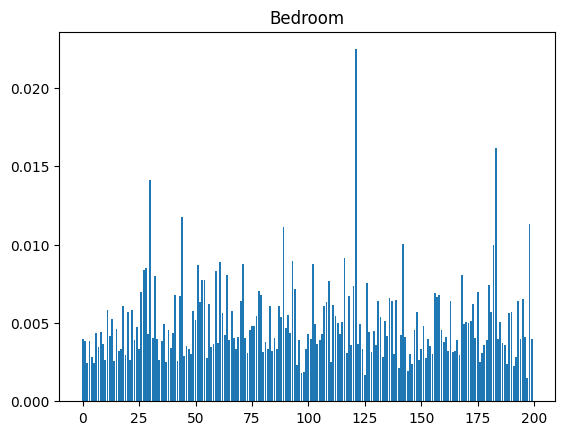

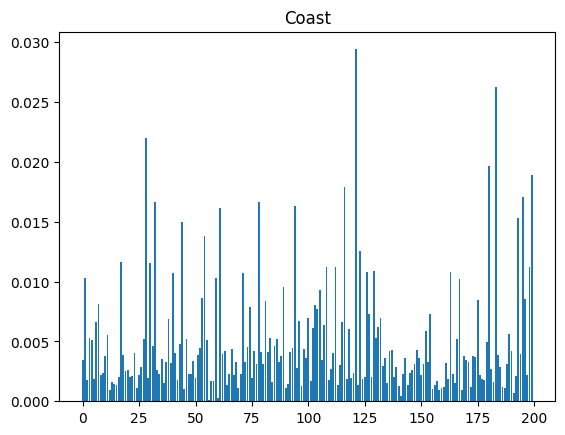

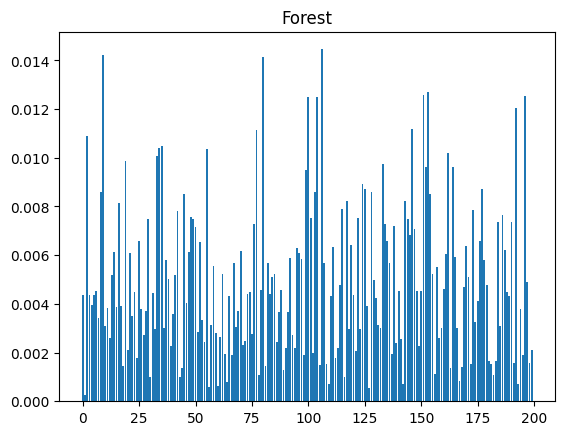

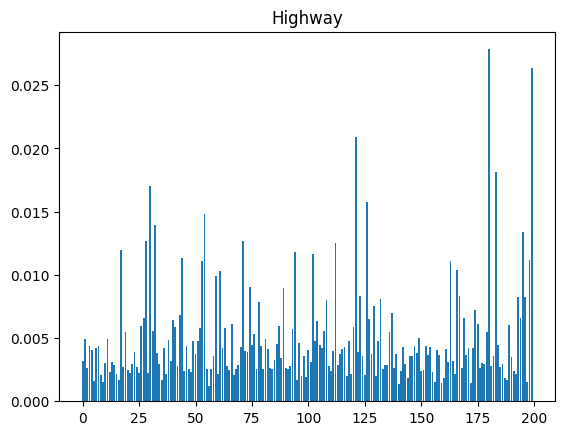

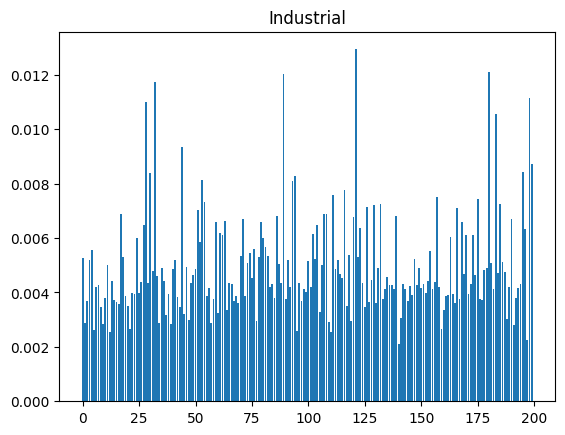

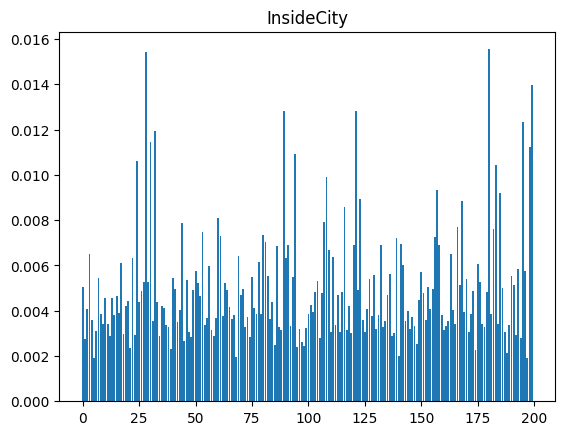

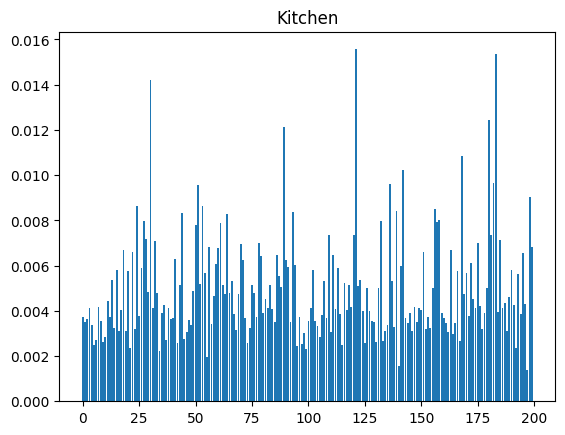

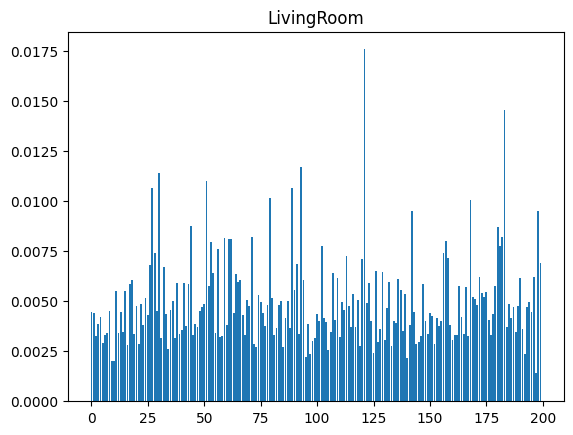

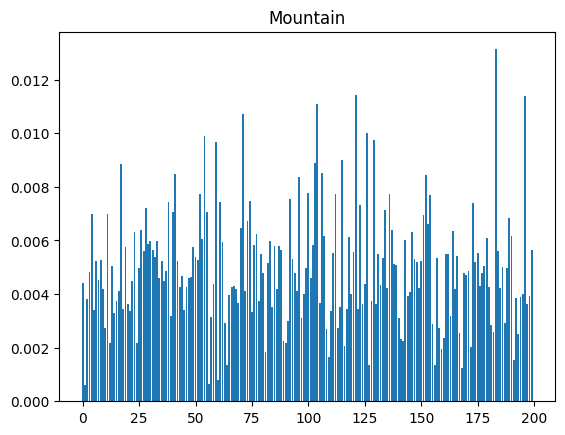

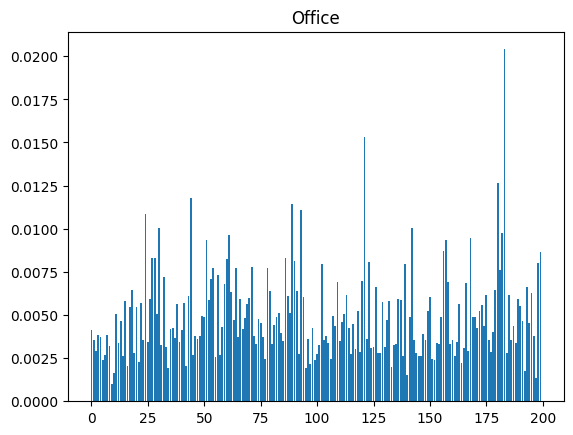

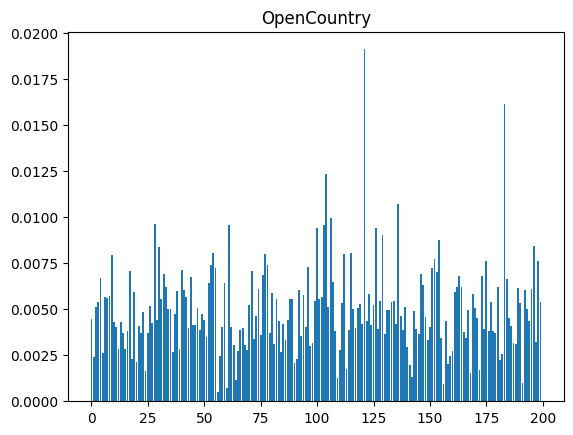

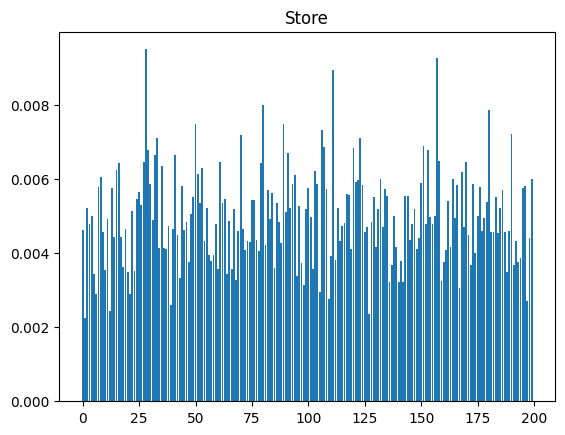

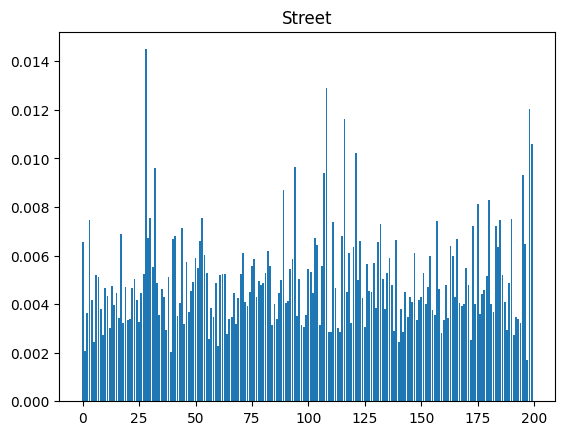

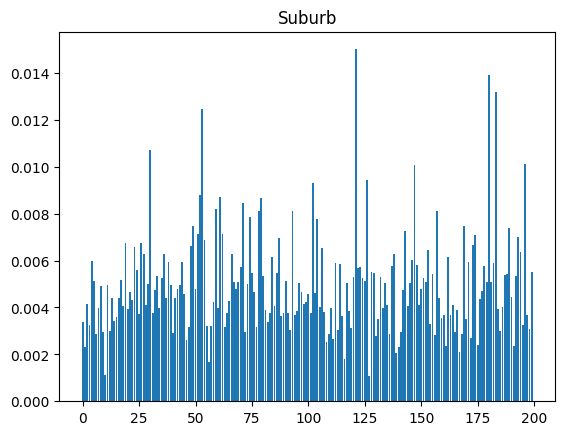

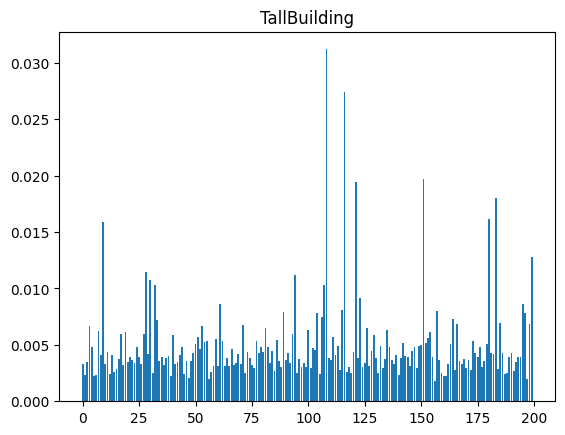

In [35]:
import matplotlib.pyplot as plt
categories = np.unique(train_labels)
category_hists = {}
for category in categories:
    category_hists[category] = np.sum(train_image_feats[train_labels == category], axis=0)
    category_hists_avg = category_hists[category] / np.sum(category_hists[category])
    plt.bar(range(len(category_hists_avg)), category_hists_avg)
    plt.title(train_image_paths[train_labels == category][0].split('\\')[1])
    plt.show()
# Looking at the histograms, bedroom and coast seem to have similar peaks in the histogram, so do industrial and insidecity. The others seem relatively distinct. Although there are quite a few histograms with peaks every couple of features, so it's not clear how well the classifier will do in terms of seperating between them. 

In [ ]:
#If you want to avoid recomputing the features while debugging the
#classifiers, you can either 'save' and 'load' the extracted features
#to/from a file.

''' Step 2: Classify each test image by training and using the appropriate classifier
 Each function to classify test features will return an N x l cell array,
 where N is the number of test cases and each entry is a string indicating
 the predicted one-hot vector for each test image. See the starter code for each function
 for more details. '''

print('Using nearest neighbor classifier to predict test set categories\n')
#TODO: YOU CODE nearest_neighbor_classify function from classifers.py
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
  

print('Using support vector machine to predict test set categories\n')
#TODO: YOU CODE svm_classify function from classifers.py
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)



print('---Evaluation---\n')
# Step 3: Build a confusion matrix and score the recognition system for 
#         each of the classifiers.
# TODO: In this step you will be doing evaluation. 
# 1) Calculate the total accuracy of your model by counting number
#   of true positives and true negatives over all. 
# 2) Build a Confusion matrix and visualize it. 
#   You will need to convert the one-hot format labels back
#   to their category name format.


# Interpreting your performance with 100 training examples per category:
#  accuracy  =   0 -> Your code is broken (probably not the classifier's
#                     fault! A classifier would have to be amazing to
#                     perform this badly).
#  accuracy ~= .10 -> Your performance is chance. Something is broken or
#                     you ran the starter code unchanged.
#  accuracy ~= .40 -> Rough performance with bag of SIFT and nearest
#                     neighbor classifier. 
#  accuracy ~= .50 -> You've gotten things roughly correct with bag of
#                     SIFT and a linear SVM classifier.
#  accuracy >= .60 -> You've added in spatial information somehow or you've
#                     added additional, complementary image features. This
#                     represents state of the art in Lazebnik et al 2006.
#  accuracy >= .85 -> You've done extremely well. This is the state of the
#                     art in the 2010 SUN database paper from fusing many 
#                     features. Don't trust this number unless you actually
#                     measure many random splits.
#  accuracy >= .90 -> You used modern deep features trained on much larger
#                     image databases.
#  accuracy >= .96 -> You can beat a human at this task. This isn't a
#                     realistic number. Some accuracy calculation is broken
#                     or your classifier is cheating and seeing the test
#                     labels.

In [6]:
import numpy as np
import os
import glob
from sklearn.cluster import KMeans

def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.
    
    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(10000 / n_image))

    # Initialize an array of features, which will store the sampled descriptors
    # keypoints = np.zeros((n_image * n_each, 2))
    descriptors = np.zeros((n_image * n_each, 128))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)
        sift_keypoints = features[:, :2]
        sift_descriptors = features[:, 2:]

        # TODO: Randomly sample n_each descriptors from sift_descriptor and store them into descriptors
        descriptors[i*n_each:(i+1)*n_each] = sift_descriptors[np.random.choice(sift_descriptors.shape[0], n_each, replace=False), :]

    # TODO: pefrom k-means clustering to cluster sampled sift descriptors into vocab_size regions.
    # You can use KMeans from sci-kit learn.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    kmeans = KMeans(n_clusters=vocab_size, random_state=0).fit(descriptors)

    return kmeans
    
def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]

    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        # Load features from each image
        features = np.loadtxt(path, delimiter=',',dtype=float)

        # TODO: Assign each feature to the closest cluster center
        # Again, each feature consists of the (x, y) location and the 128-dimensional sift descriptor
        # You can access the sift descriptors part by features[:, 2:]
        closest_cluster = kmeans.predict(features[:, 2:])        

        # TODO: Build a histogram normalized by the number of descriptors
        image_feats[i] = np.histogram(closest_cluster, bins=vocab_size, range=(0, vocab_size), density=True)[0]  

    return image_feats

def load(ds_path):
    """ Load from the training/testing dataset.

    Parameters
    ----------
    ds_path: path to the training/testing dataset.
             e.g., sift/train or sift/test 
    
    Returns
    -------
    image_paths: a (n_sample, 1) array that contains the paths to the descriptors. 
    labels: class labels corresponding to each image
    """
    # Grab a list of paths that matches the pathname
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)
    image_paths = np.asarray(files)
 
    # Get class labels
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_files)

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

    # Randomize the order
    idx = np.random.choice(n_files, size=n_files, replace=False)
    image_paths = image_paths[idx]
    labels = labels[idx]

    return image_paths, labels


if __name__ == "__main__":
    paths, labels = load("sift/train")
    #build_vocabulary(paths, 10)


In [5]:
 #Starter code prepared by Borna Ghotbi for computer vision
 #based on MATLAB code by James Hay

'''This function will predict the category for every test image by finding
the training image with most similar features. Instead of 1 nearest
neighbor, you can vote based on k nearest neighbors which will increase
performance (although you need to pick a reasonable value for k). '''

def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.

    Usefull funtion:
    	
    	# You can use knn from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    '''
    return predicted_labels



'''This function will train a linear SVM for every category (i.e. one vs all)
and then use the learned linear classifiers to predict the category of
very test image. Every test feature will be evaluated with all 15 SVMs
and the most confident SVM will "win". Confidence, or distance from the
margin, is W*X + B where '*' is the inner product or dot product and W and
B are the learned hyperplane parameters. '''

def svm_classify(train_image_feats, train_labels, test_image_feats):

    '''
    Parameters
        ----------
        train_image_feats:  is an N x d matrix, where d is the dimensionality of the feature representation.
        train_labels: is an N x l cell array, where each entry is a string 
        			  indicating the ground truth one-hot vector for each training image.
    	test_image_feats: is an M x d matrix, where d is the dimensionality of the
    					  feature representation. You can assume M = N unless you've modified the starter code.
        
    Returns
        -------
    	is an M x l cell array, where each row is a one-hot vector 
        indicating the predicted category for each test image.

    Usefull funtion:
    	
    	# You can use svm from sci-kit learn.
        # Reference: https://scikit-learn.org/stable/modules/svm.html

    '''
    return predicted_labels

